In [1]:
import torch
from sklearn.model_selection import RepeatedKFold
import numpy as np 
from dataloader import Dataset, Load_Dataset_A, Load_Dataset_B, Load_Dataset_C
import os
from model import fNIRS_T, fNIRS_PreT
import model_init

import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn, einsum
from einops.layers.torch import Rearrange
import math
import ttt
import model

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
import matplotlib.pyplot as plt

/U_PZL2022KF0005/home/luowanxiang/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# [    0           1             2           3                    4                    5                   6           ]
# ['fNIRS-T', 'fNIRS-PreT',  'CT-Net', 'fNIRS_TTT_LM', 'fNIRS_TTT_M', 'fNIRS_TTT_LL', 'fNIRS_TTT_L']
models = ['fNIRS-T', 'fNIRS-PreT',  'CT-Net', 'fNIRS_TTT_LM', 'fNIRS_TTT_M', 'fNIRS_TTT_LL', 'fNIRS_TTT_L']

dataset = ['A', 'B', 'C']

batch_size=128

device_id=0

def visual_feature_grad(net, inputs, mean= True):
    last_layer_name, last_layer = list(net.named_children())[-1]
    model = net
    target_layers = [eval(f"net.{last_layer_name}")]
    input_tensor = inputs
    cam = FullGrad(model=model, target_layers=target_layers)
    # targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    if mean:
        return grayscale_cam.mean(0)
    else:
        return grayscale_cam


def cal_all_samples(dataset_id, models_id, device, net_num=1):

    print(f"processing:{models[models_id]}, at dataset:{dataset[dataset_id]}")

    if dataset[dataset_id] == 'A':
        if models[models_id] == 'fNIRS-T' or models[models_id].startswith('fNIRS_TTT') or models[models_id]=="debug":
            feature, label = Load_Dataset_A("data/A", model='fNIRS-T')
        elif models[models_id] == 'fNIRS-PreT':
            feature, label = Load_Dataset_A("data/A", model='fNIRS-PreT')

    elif dataset[dataset_id] == 'B':
        feature, label = Load_Dataset_B("data/B")

    elif dataset[dataset_id] == 'C':

        feature, label = Load_Dataset_C("data/C")

    _, _, channels, sampling_points = feature.shape

    feature = feature.reshape((label.shape[0], -1))
    y_train = label
    X_train = feature
    X_train = X_train.reshape((X_train.shape[0], 2, channels, -1))
    train_set = Dataset(X_train, y_train, transform=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    net = model_init.init_model_MK2(dataset=dataset[dataset_id], model=models[models_id], device=device)
    net.load_state_dict(torch.load(f"save/{dataset[dataset_id]}/KFold/{models[models_id]}/{net_num}/model.pt", map_location='cuda'))
    net.eval()
    all_ndarray = "str"
    # 单输入测试
    bs=128
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if inputs.shape[0]!=bs:break
        visual_ndarray = visual_feature_grad(net,inputs, mean=False)
        if type(all_ndarray) == type("str"):
            all_ndarray = visual_ndarray
        else:
            all_ndarray =  np.concatenate((all_ndarray, visual_ndarray), axis=0)
    return all_ndarray

def print_visual_figure(t_a, t_b, t_c, model_name="None"):
    # 创建不同大小的示例数据
    data1 = t_a
    data2 = t_b
    data3 = t_c

    # 创建子图
    fig, axes = plt.subplots(1, 3, figsize=(30, 5))  # 1行3列的子图

    # 绘制第一个图像
    axes[0].imshow(data1, cmap='viridis', aspect='auto')
    axes[0].set_title("Dataset A",fontsize=22)
    axes[0].set_xlim(0, data1.shape[1])
    axes[0].set_ylim(0, data1.shape[0])
    axes[0].set_xticks(np.arange(0, data1.shape[1] + 1, 20))  # 每隔10取一个刻度
    axes[0].set_yticks(np.arange(0, data1.shape[0] + 1, 13))

    for spine in axes[0].spines.values():
        spine.set_visible(False)  # 移除边框

    # 绘制第二个图像
    axes[1].imshow(data2, cmap='viridis', aspect='auto')
    axes[1].set_title("Dataset B",fontsize=22)
    axes[1].set_xlim(0, data2.shape[1])
    axes[1].set_ylim(0, data2.shape[0])
    axes[1].set_xticks(np.arange(0, data2.shape[1] + 1, 20))
    axes[1].set_yticks(np.arange(0, data2.shape[0] + 1, 4))  # 对较小尺寸的数据，步长取5
    for spine in axes[1].spines.values():
        spine.set_visible(False)  # 移除边框

    # 绘制第三个图像
    axes[2].imshow(data3, cmap='viridis', aspect='auto')
    axes[2].set_title("Dataset C",fontsize=22)
    axes[2].set_xlim(0, data3.shape[1])
    axes[2].set_ylim(0, data3.shape[0])
    axes[2].set_xticks(np.arange(0, data3.shape[1] + 1, 20))
    axes[2].set_yticks(np.arange(0, data3.shape[0] + 1, 5))

    for spine in axes[2].spines.values():
        spine.set_visible(False)  # 移除边


    plt.tight_layout()
    plt.savefig(f"Vis_{model_name}.tiff")
    plt.show()


processing:fNIRS-T, at dataset:A
1  OK
2  OK
3  OK
4  OK
5  OK
6  OK
7  OK
8  OK
feature (348, 2, 52, 140)
label (348,)
torch.Size([348, 2, 52, 140])
torch.Size([348])
init_model: dataset 'A'
init fNIRS_T(
  (to_patch_embedding): Sequential(
    (0): Conv2d(2, 8, kernel_size=(5, 30), stride=(1, 4))
    (1): Rearrange('b c h w  -> b w (c h)')
    (2): Linear(in_features=384, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (to_channel_embedding): Sequential(
    (0): Conv2d(2, 8, kernel_size=(1, 30), stride=(1, 4))
    (1): Rearrange('b c h w  -> b w (c h)')
    (2): Linear(in_features=416, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_patch): Dropout(p=0.0, inplace=False)
  (transformer_patch): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

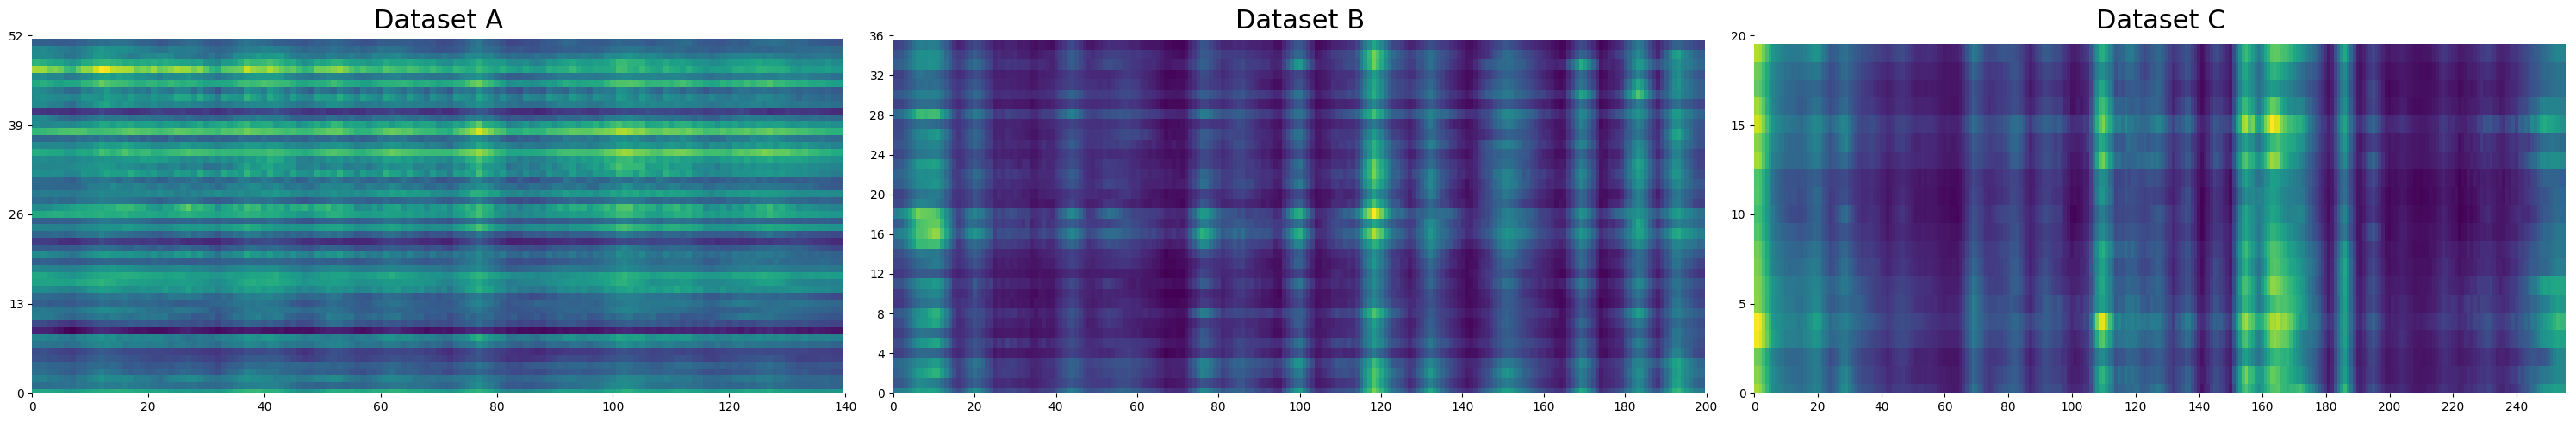

In [5]:
mid = 0
device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
test_a = cal_all_samples(0, mid, device)
test_b = cal_all_samples(1, mid, device)
test_c = cal_all_samples(2, mid, device)
print_visual_figure(torch.tensor(test_a.mean(0)), 
                    torch.tensor(test_b.mean(0)), 
                    torch.tensor(test_c.mean(0)), 
                    model_name=models[mid]+"_2")

In [ ]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
for i in [0,1,2,4,6]:
    test_a = cal_all_samples(0, i, device)
    test_b = cal_all_samples(1, i, device)
    test_c = cal_all_samples(2, i, device)
    print_visual_figure(torch.tensor(test_a.mean(0)), 
                        torch.tensor(test_b.mean(0)), 
                        torch.tensor(test_c.mean(0)), 
                        model_name=models[i])